In [1]:
##Importing all necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import  stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [2]:
#Importing train data
df = pd.read_csv(r"C:\Users\jjjib\Desktop\Projects\FlipRobo\Ratings Prediction Project 30-05\sol\Review.csv")

# Data Understanding

In [3]:
#Visualizing the train dataset 
df.head()

,Unnamed: 0,Rating,Review
0,0,1,Display has failed in just 19 days. Never expe...
1,1,1,Worst experience everDay 1 dead pixelTechnicia...
2,2,1,Display failed just after 3 months of usage. B...
3,3,1,Very poor performance .......mother board is d...
4,4,1,Screen didnot turn on the second time after pu...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   Rating      20000 non-null  int64 
 2   Review      19943 non-null  object
dtypes: int64(2), object(1)
memory usage: 468.9+ KB


In [19]:
df.dropna(inplace=True)
df = df.drop(columns='Unnamed: 0')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19943 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  19943 non-null  int64 
 1   Review  19943 non-null  object
dtypes: int64(1), object(1)
memory usage: 467.4+ KB


<AxesSubplot:>

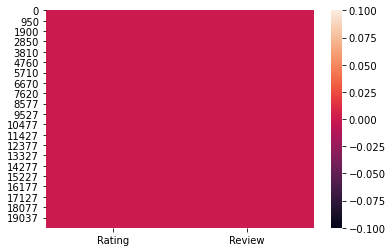

In [21]:
#Visualization of null data
sns.heatmap(df.isnull())

# Data Cleaning and Analysis

In [24]:
# We will break down the comment text into words and characters to look at the length
df['length'] = df['Review'].str.len()
df.head(2)

,Rating,Review,length
0,1,Display has failed in just 19 days. Never expe...,154
1,1,Worst experience everDay 1 dead pixelTechnicia...,128


Now we will clean the comment text to fitler out the stopwords and punctuation, email, websites and phone numbers

In [25]:
# Convert all messages to lower case
df['Review'] = df['Review'].str.lower()

# Replace email addresses with 'email'
df['Review'] = df['Review'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
df['Review'] = df['Review'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

# Replace money symbols with 'moneysymb' 
df['Review'] = df['Review'].str.replace(r'£|\$', 'dollars')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['Review'] = df['Review'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

# Replace numbers with 'numbr'
df['Review'] = df['Review'].str.replace(r'\d+(\.\d+)?', 'numbr')


df['Review'] = df['Review'].apply(lambda x: ' '.join(term for term in x.split() if term not in string.punctuation))

# Defining stop words
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['Review'] = df['Review'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

lem = WordNetLemmatizer()
df['Review'] = df['Review'].apply(lambda x: ' '.join(lem.lemmatize(t) for t in x.split()))

In [26]:
# Now we see the length of the text after filtering out the necessary stopwords and punctuations
df['clean_length'] = df.Review.str.len()
df.head()

,Rating,Review,length,clean_length
0,1,display failed numbr days. never expected bad ...,154,103
1,1,worst experience everday numbr dead pixeltechn...,128,121
2,1,display failed numbr month usage. build qualit...,68,53
3,1,poor performance .......mother board dead bwit...,171,138
4,1,screen didnot turn second time purchase.. retu...,227,149


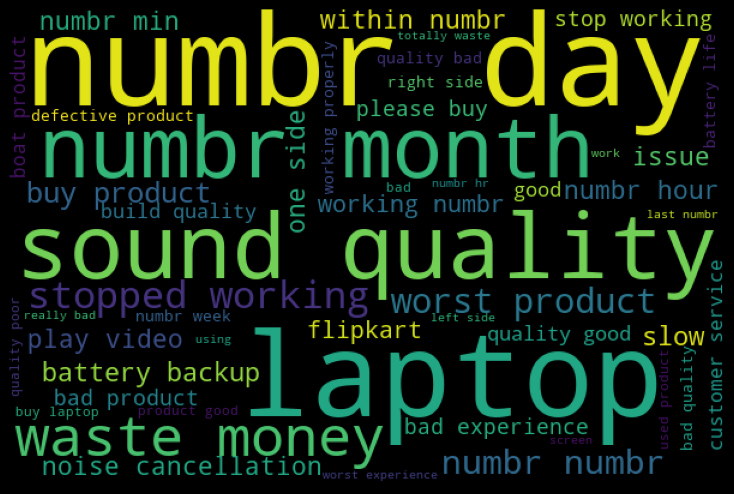

In [34]:
#Getting sense of loud words which get 1 rating
hams = df['Review'][df['Rating']==1]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

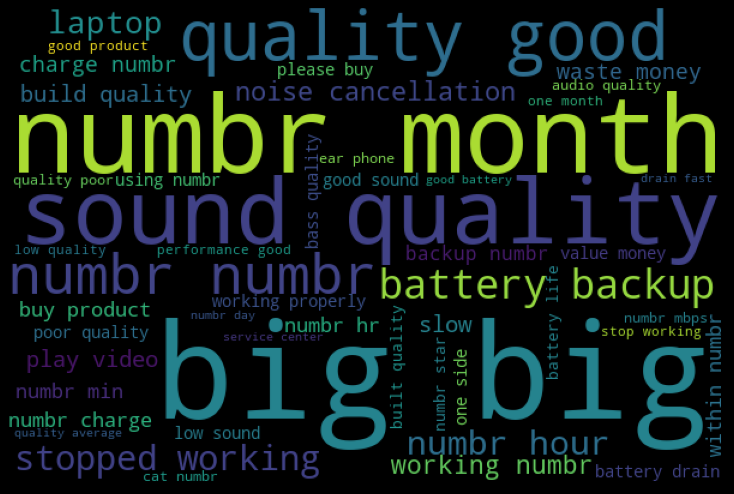

In [35]:
#Getting sense of loud words which get 2 rating
hams = df['Review'][df['Rating']==2]
spam_cloud = WordCloud(width=600,height=400,background_color='black',max_words=50).generate(' '.join(hams))
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [36]:
#Creating a combined target column
target_data = df['Rating']
print(df['Rating'].value_counts())

3    4000
4    4000
1    3990
2    3983
5    3970
Name: Rating, dtype: int64


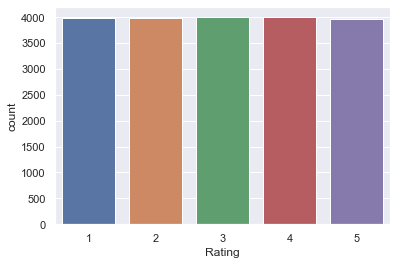

In [37]:
#Checking the imbalance
sns.set()
sns.countplot(x="Rating" , data = df)
plt.show()

In [38]:
#  Convert text into vectors using TF-IDF
tf_vec = TfidfVectorizer(max_features = 10000, stop_words='english')
features = tf_vec.fit_transform(df['Review'])
x = features
y = df['Rating']

# Best Random State

In [46]:
maxRS = 0
maxAcc = 0
for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=i)
    lg = LogisticRegression()
    lg.fit(x_train, y_train)
    pred = lg.predict(x_test)
    acc = accuracy_score(y_test, pred)
    if acc>maxAcc:
        maxAcc = acc
        maxRS = i
print("Max accuracy: \t", maxAcc)
print("Random State: \t", maxRS)

Max accuracy: 	 0.762995152933311
Random State: 	 3


In [50]:
# Test train split
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=maxRS,test_size=.30)

# Model

Logistic Regression

In [51]:
lg = LogisticRegression()
lg.fit(x_train, y_train)
y_pred_train = lg.predict(x_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = lg.predict(x_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

Training accuracy is 0.8222063037249283
Test accuracy is 0.762995152933311
[[1082   60   58   21   17]
 [ 116  937  103   33    8]
 [  78   94  821  107   83]
 [  11   24   66  836  267]
 [  38   24   36  174  889]]
              precision    recall  f1-score   support

           1       0.82      0.87      0.84      1238
           2       0.82      0.78      0.80      1197
           3       0.76      0.69      0.72      1183
           4       0.71      0.69      0.70      1204
           5       0.70      0.77      0.73      1161

    accuracy                           0.76      5983
   macro avg       0.76      0.76      0.76      5983
weighted avg       0.76      0.76      0.76      5983



Decision Tree Classifier

In [52]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred_train = dt.predict(x_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = dt.predict(x_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

Training accuracy is 0.947134670487106
Test accuracy is 0.7715193046966404
[[1004   90   61   27   56]
 [  87 1003   48   31   28]
 [  70   49  869   77  118]
 [  23   20   74  847  240]
 [  35   22   52  159  893]]
              precision    recall  f1-score   support

           1       0.82      0.81      0.82      1238
           2       0.85      0.84      0.84      1197
           3       0.79      0.73      0.76      1183
           4       0.74      0.70      0.72      1204
           5       0.67      0.77      0.72      1161

    accuracy                           0.77      5983
   macro avg       0.77      0.77      0.77      5983
weighted avg       0.77      0.77      0.77      5983



Random Forest Classifier

In [53]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred_train = rf.predict(x_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = rf.predict(x_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

Training accuracy is 0.947134670487106
Test accuracy is 0.8041116496740766
[[1104   34   46    9   45]
 [ 118  982   54   19   24]
 [  84   28  886   75  110]
 [  13    5   55  858  273]
 [  22    2   26  130  981]]
              precision    recall  f1-score   support

           1       0.82      0.89      0.86      1238
           2       0.93      0.82      0.87      1197
           3       0.83      0.75      0.79      1183
           4       0.79      0.71      0.75      1204
           5       0.68      0.84      0.76      1161

    accuracy                           0.80      5983
   macro avg       0.81      0.80      0.80      5983
weighted avg       0.81      0.80      0.80      5983



XGBoost

In [54]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred_train = xgb.predict(x_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = xgb.predict(x_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[17:08:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy is 0.8530085959885387
Test accuracy is 0.7850576633795755
[[1083   81   32   16   26]
 [ 118  985   59   16   19]
 [  72   73  864   80   94]
 [  23   21   60  820  280]
 [  23   36   25  132  945]]
              precision    recall  f1-score   support

           1       0.82      0.87      0.85      1238
           2       0.82      0.82      0.82      1197
           3       0.83      0.73      0.78      1183
           4       0.77      0.68      0.72      1204
           5       0.69      0.81      0.75      1161

    accuracy                           0.79      5983
   macro avg       0.79      0.78      0.78      5983
weighted avg       0.79      0.79     

K Neighbors Classifier

In [55]:
knn=KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred_train = knn.predict(x_train)
print('Training accuracy is {}'.format(accuracy_score(y_train, y_pred_train)))
y_pred_test = knn.predict(x_test)
print('Test accuracy is {}'.format(accuracy_score(y_test,y_pred_test)))
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

Training accuracy is 0.7666189111747851
Test accuracy is 0.7193715527327428
[[881  20  31  34 272]
 [ 43 958  27  23 146]
 [ 41  20 770  61 291]
 [ 20   7  49 752 376]
 [ 13   2  25 178 943]]
              precision    recall  f1-score   support

           1       0.88      0.71      0.79      1238
           2       0.95      0.80      0.87      1197
           3       0.85      0.65      0.74      1183
           4       0.72      0.62      0.67      1204
           5       0.46      0.81      0.59      1161

    accuracy                           0.72      5983
   macro avg       0.77      0.72      0.73      5983
weighted avg       0.78      0.72      0.73      5983



We see that Random Forest classifier works best and hence we shall use this

# Saving the best model

In [57]:
import joblib
joblib.dump(rf,"rev.pkl")

['rev.pkl']